In [1]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.mask import mask
from rasterio.windows import from_bounds
from shapely.geometry import box

# Paths
input_file = "E:\\Brazil Validation\\Soybeans\\2000.tif"  # Input raster file for Brazil
area_raster_path = "E:\\Brazil Validation\\Soybeans\\Area.tif"  # Area raster for Brazil
output_folder = 'E:\\Brazil Validation\\Soybeans\\Resampled\\Total AH'  # Folder to save the output rasters

# Function to reproject a raster to WGS84
def reproject_to_wgs84(input_path, output_path):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:4326',
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest)

# Function to calculate the area of a pixel in hectares at a given latitude
def pixel_area_in_hectares(lat):
    # Constants for the calculations
    a = 6378137  # Semi-major axis of the earth in meters
    b = 6356752.3142  # Semi-minor axis of the earth in meters
    e = np.sqrt(1 - (b/a)**2)  # Eccentricity

    # Convert latitude to radians
    lat_rad = np.radians(lat)

    # Calculate the meridian radius of curvature
    M = (a * (1 - e**2)) / (1 - e**2 * np.sin(lat_rad)**2)**(3/2)

    # Calculate the prime vertical radius of curvature
    N = a / np.sqrt(1 - e**2 * np.sin(lat_rad)**2)

    # Length of a degree of latitude (north-south) in meters
    lat_degree_length = np.pi / 180 * M

    # Length of a degree of longitude (east-west) in meters
    lon_degree_length = np.pi / 180 * np.cos(lat_rad) * N

    # Area of one pixel in square meters
    pixel_area_m2 = (lat_degree_length * lon_degree_length) * (0.00025**2)

    # Convert to hectares (1 hectare = 10,000 square meters)
    return pixel_area_m2 / 10000

# Create necessary directories if they don't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

reprojected_folder = os.path.join(output_folder, 'Reprojected')
clipped_folder = os.path.join(output_folder, 'Clipped')
aggregated_folder = os.path.join(output_folder, 'Aggregated')

for folder in [reprojected_folder, clipped_folder, aggregated_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Process the input file
base_name = os.path.splitext(os.path.basename(input_file))[0]
reprojected_crop_raster_path = os.path.join(reprojected_folder, f'reprojected_{base_name}.tif')
reprojected_area_raster_path = os.path.join(reprojected_folder, 'reprojected_area_layer_wgs84.tif')
clipped_area_path = os.path.join(clipped_folder, f'clipped_area_{base_name}.tif')
output_raster_path = os.path.join(aggregated_folder, f'{base_name}.tif')

# Reproject the CropScape raster to WGS84
reproject_to_wgs84(input_file, reprojected_crop_raster_path)

# Reproject the area raster to WGS84 only once
if not os.path.exists(reprojected_area_raster_path):
    reproject_to_wgs84(area_raster_path, reprojected_area_raster_path)

print(f"Reprojected {input_file} to WGS84 successfully.")

# Clip the area map based on the extent of the reprojected crop raster
with rasterio.open(reprojected_crop_raster_path) as src:
    crop_bounds = src.bounds
    crop_extent = [box(*crop_bounds)]

with rasterio.open(reprojected_area_raster_path) as src:
    out_image, out_transform = mask(src, crop_extent, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "crs": 'EPSG:4326'
    })

    with rasterio.open(clipped_area_path, "w", **out_meta) as dest:
        dest.write(out_image)

print(f"Area map clipped for {input_file} successfully.")

# Aggregate the 30m raster based on the 5 arcminute grid cells of the area map
with rasterio.open(clipped_area_path) as area_src, rasterio.open(reprojected_crop_raster_path) as crop_src:
    area_data = area_src.read(1)
    area_transform = area_src.transform
    crop_transform = crop_src.transform
    aggregated_data = np.zeros(area_data.shape, dtype='float32')

    for i in range(area_data.shape[0]):
        for j in range(area_data.shape[1]):
            if area_data[i, j] > 0:  # Only process cells with area values > 0
                cell_bounds = rasterio.windows.bounds(((i, i + 1), (j, j + 1)), transform=area_transform)
                window = from_bounds(*cell_bounds, transform=crop_transform)
                window_data = crop_src.read(1, window=window, boundless=True)
                aggregated_data[i, j] = np.sum(window_data) * 0.09  # Convert to hectares

print(f"Data aggregated for {input_file} successfully.")

# Save the aggregated data
output_transform = area_transform

# Create the metadata for the output file
out_meta = area_src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": aggregated_data.shape[0],
    "width": aggregated_data.shape[1],
    "transform": output_transform,
    "crs": 'EPSG:4326',
    "dtype": 'float32',
    "nodata": 0
})

with rasterio.open(output_raster_path, 'w', **out_meta) as dst:
    dst.write(aggregated_data, 1)

print(f"Aggregated data saved for {input_file} successfully.")


KeyboardInterrupt: 

In [8]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterstats import zonal_stats

# Paths
input_raster_path = "E:\\Brazil Validation\\Soybeans\\Clipped\\2000.tif"
shapefile_path = "D:\\PhD_Udel\\MICRA_2015\\DOwnscaling\\NASAOCE\\Shapefile\\gadm41_BRA_1.shp"
output_directory = 'E:\\Brazil Validation\\Soybeans\\Resampled\\2000'

# Read shapefile
gdf = gpd.read_file(shapefile_path)

# Process the input raster and calculate zonal statistics
for index, row in gdf.iterrows():
    # Clip the input raster for the current province
    geom = row['geometry']
    with rasterio.open(input_raster_path) as src:
        out_image, out_transform = mask(src, [geom], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": 0  # Set a valid nodata value for the data type uint8
        })
    
    # Calculate zonal statistics (sum) within each zone
    stats = zonal_stats(geom, out_image[0], affine=out_transform, stats="sum")
    zonal_sum = np.array([stat["sum"] for stat in stats])  # Convert to numpy array
    
    # Ensure zonal_sum has the same shape as the raster band
    zonal_sum = zonal_sum.reshape(out_image.shape[0], out_image.shape[1])
    
    # Write zonal sum to the output raster
    clipped_raster_path = os.path.join(output_directory, f"clipped_{row['unit_code']}.tif")
    with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
        dest.write(zonal_sum, 1)


C:\Users\endal\anaconda3\envs\mirca_2015\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


ValueError: cannot reshape array of size 1 into shape (1,16125)

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, transform
from rasterio.enums import Resampling
import geopandas as gpd

def pixel_area_in_hectares(lat, cell_size_degrees):
    # Constants for the calculations
    a = 6378137  # Semi-major axis of the earth in meters
    b = 6356752.3142  # Semi-minor axis of the earth in meters
    e = np.sqrt(1 - (b/a)**2)  # Eccentricity
    lat_rad = np.radians(lat)  # Convert latitude to radians
    M = (a * (1 - e**2)) / (1 - e**2 * np.sin(lat_rad)**2)**(1.5)  # Meridian radius of curvature
    N = a / np.sqrt(1 - e**2 * np.sin(lat_rad)**2)  # Prime vertical radius of curvature
    lat_degree_length = np.pi / 180 * M  # Length of a degree of latitude in meters
    lon_degree_length = np.pi / 180 * np.cos(lat_rad) * N  # Length of a degree of longitude in meters
    pixel_area_m2 = (lat_degree_length * lon_degree_length) * (cell_size_degrees**2)  # Pixel area in m^2
    return pixel_area_m2 / 10000  # Convert m^2 to hectares

# Paths
input_raster_path = "E:\\Brazil Validation\\Soybeans\\Clipped\\2000.tif"
output_directory = 'E:\\Brazil Validation\\Soybeans\\Resampled\\2000'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Processing the raster
with rasterio.open(input_raster_path) as src:
    # Define the new transform and width/height for 5 arc-minute resolution
    transform, width, height = calculate_default_transform(
        src.crs, src.crs, src.width, src.height, *src.bounds,
        resolution=(0.083333, 0.083333)  # 5 arc minutes in degrees
    )

    # Define the metadata for the new aggregated raster
    kwargs = src.meta.copy()
    kwargs.update({
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': src.nodata,
        'dtype': 'float32'  # Adjust dtype to float32 if necessary
    })

    # Initialize an empty array for the aggregated data
    aggregated_data = np.zeros((height, width), dtype='float32')
    
    # Reproject and aggregate the data using 'mean' reduction
    reproject(
        source=rasterio.band(src, 1),
        destination=aggregated_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=src.crs,
        resampling=Resampling.average
    )

    # Adjust the values based on the pixel area in hectares
    for i in range(height):
        for j in range(width):
            # Calculate the latitude for the current pixel
            lat, lon = rasterio.transform.xy(transform, i, j, offset='center')
            
            # Calculate the pixel area in hectares
            pixel_area_ha = pixel_area_in_hectares(lat, 0.083333)  # cell size for 5 arc minutes
            
            # Multiply the pixel value by its area in hectares
            aggregated_data[i, j] *= pixel_area_ha

    # Save the aggregated raster
    output_path = os.path.join(output_directory, 'E:\\Brazil Validation\\Soybeans\\Resampled\\2000\\2000.tif')
    with rasterio.open(output_path, 'w', **kwargs) as dst:
        dst.write(aggregated_data, 1)


In [23]:
import numpy as np
import rasterio

# Paths to your raster files
irrigated_area_raster_path = "E:\\Brazil Validation\\Soybeans\\Resampled\\Irrigated\\2015.tif"
crop_area_raster_path = "E:\\Brazil Validation\\Soybeans\\Resampled\\Final\\2015.tif"
output_raster_path = "E:\\Brazil Validation\\Soybeans\\Resampled\\GLAD\\2015.tif"

# Open the irrigated area raster file
with rasterio.open(irrigated_area_raster_path) as irrigated_src:
    irrigated_data = irrigated_src.read(1)  # Read the first band

# Open the crop area raster file
with rasterio.open(crop_area_raster_path) as crop_src:
    crop_data = crop_src.read(1)  # Read the first band
    crop_meta = crop_src.meta  # We'll use the same metadata for the output file

# Resize crop_data to match the shape of irrigated_data
crop_data_resized = np.zeros_like(irrigated_data)
crop_data_resized[:, :crop_data.shape[1]] = crop_data

# Perform the conditional check
# Keep crop value where both rasters have values greater than 0, else set to zero
output_data = np.where((irrigated_data > 0) & (crop_data_resized > 0), crop_data_resized, 0)

# Save the output data to a new TIFF file
with rasterio.open(output_raster_path, 'w', **crop_meta) as out_dst:
    out_dst.write(output_data, 1)  # Write the output data to the first band


In [1]:
# import matplotlib.pyplot as plt
# import rasterio
# import numpy as np
# import geopandas as gpd
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# from rasterio.enums import Resampling

# # Define new colors for the plot
# darker_blue = (0, 0, 139/255)  # Dark Blue for agreement
# light_blue = (101/255, 67/255, 33/255)  # Light Blue for MIRCA-OS Only
# dark_red = (139/255, 0, 0)  # Dark Red for MIRCA2000 Only

# # Function to read and reproject raster data
# def read_raster(file_path, target_crs):
#     with rasterio.open(file_path) as src:
#         transform, width, height = calculate_default_transform(
#             src.crs, target_crs, src.width, src.height, *src.bounds)
#         kwargs = src.meta.copy()
#         kwargs.update({
#             'crs': target_crs,
#             'transform': transform,
#             'width': width,
#             'height': height
#         })
        
#         data = np.zeros((src.count, height, width), dtype=src.meta['dtype'])
        
#         for i in range(1, src.count + 1):
#             reproject(
#                 source=rasterio.band(src, i),
#                 destination=data[i-1],
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=target_crs,
#                 resampling=Resampling.nearest
#             )
        
#         return data[0], transform, kwargs

# # Function to resample raster data to match target dimensions and resolution
# def resample_raster(source_raster, source_transform, source_crs, target_meta):
#     destination = np.zeros((target_meta['height'], target_meta['width']), dtype=source_raster.dtype)
    
#     reproject(
#         source=source_raster,
#         destination=destination,
#         src_transform=source_transform,
#         src_crs=source_crs,
#         dst_transform=target_meta['transform'],
#         dst_crs=target_meta['crs'],
#         resampling=Resampling.nearest
#     )
    
#     return destination

# # Function to get the extent of a raster from its transform
# def get_extent(transform, width, height):
#     left = transform[2]
#     top = transform[5]
#     right = left + transform[0] * width
#     bottom = top + transform[4] * height
#     return (left, right, bottom, top)

# # Function to clean raster data
# def clean_raster_data(raster_data, extreme_value_threshold=0):
#     cleaned_data = np.where(raster_data < extreme_value_threshold, 0, raster_data)
#     return cleaned_data

# # Function to compare rasters and return presence/absence data
# def compare_rasters(raster1, raster2):
#     agree = (raster1 > 0) & (raster2 > 0)
#     mirca_os_only = (raster1 > 0) & (raster2 == 0)
#     mirca_2000_only = (raster1 == 0) & (raster2 > 0)
#     return agree, mirca_os_only, mirca_2000_only

# # Function to calculate agreement percentages for the bar chart
# def calculate_percentages(agree, mirca_os_only, mirca_2000_only):
#     agree_count = np.sum(agree)
#     mirca_os_only_count = np.sum(mirca_os_only)
#     mirca_2000_only_count = np.sum(mirca_2000_only)
#     total_valid_pixels = agree_count + mirca_os_only_count + mirca_2000_only_count
#     agree_pct = (agree_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
#     mirca_os_only_pct = (mirca_os_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
#     mirca_2000_only_pct = (mirca_2000_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
#     return agree_pct, mirca_os_only_pct, mirca_2000_only_pct

# # Load the shapefile and reproject it to WGS84
# shapefile_path = "D:\\PhD_Udel\\MICRA_2015\\DOwnscaling\\NASAOCE\\Shapefile\\gadm41_BRA_1.shp"
# world = gpd.read_file(shapefile_path)
# world = world.to_crs(epsg=4326)

# # Directories for raster data
# base_dir_os = "E:\\Brazil Validation\\Total Soy"
# base_dir_2000 ="E:\\Brazil Validation\\Soybeans\\Resampled\\Final"
# # Crop names
# crops = ["2000","2005","2010", "2015"]
# # Set up the plot dimensions and resolution
# figsize = (10, 6)
# dpi = 100  # Adjust the dpi to your preference for resolution

# # Create a plot for each crop
# for i, crop in enumerate(crops):  # Use enumerate to get the index
#     fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [3, 1]})
#     # Process rasters
#     raster1, transform1, meta1 = read_raster(f'{base_dir_os}/{crop}.tif', 'EPSG:4326')
#     raster2, transform2, meta2 = read_raster(f'{base_dir_2000}/{crop}.tif', 'EPSG:4326')

#     # Resample raster2 to match raster1 dimensions and resolution
#     raster2_resampled = resample_raster(raster2, transform2, meta2['crs'], meta1)

#     # Clean rasters
#     raster1 = clean_raster_data(raster1)
#     raster2_resampled = clean_raster_data(raster2_resampled)
    
#     # Compare rasters
#     agree, mirca_os_only, mirca_2000_only = compare_rasters(raster1, raster2_resampled)
#     agree_pct, mirca_os_only_pct, mirca_2000_only_pct = calculate_percentages(agree, mirca_os_only, mirca_2000_only)
    
#     # Initialize combined RGB array with white background
#     combined_rgb = np.ones((raster1.shape[0], raster1.shape[1], 3))
#     # Apply new colors based on the comparison
#     combined_rgb[agree] = darker_blue  # Dark Blue for agreement
#     combined_rgb[mirca_os_only] = light_blue  
#     combined_rgb[mirca_2000_only] = dark_red  # Dark Red for
#     # Plot map
#     extent = get_extent(transform1, raster1.shape[1], raster1.shape[0])
#     ax_map.imshow(combined_rgb, extent=extent)
#     ax_map.set_title(f'{crop}', fontsize=24)
#     ax_map.set_frame_on(False)
#     world.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

#     # Remove x and y ticks
#     ax_map.set_xticks([])
#     ax_map.set_yticks([])

#     # Plot bar chart on ax_bar
#     labels = ['Agreement', 'MIRCA_OS Only', 'MirAD-US Only']
#     percentages = [agree_pct, mirca_os_only_pct, mirca_2000_only_pct]
#     ax_bar.bar(labels, percentages, color=[darker_blue, light_blue, dark_red])
#     ax_bar.set_ylabel('Percentage (%)',  fontsize=20)
#     ax_bar.set_ylim(0, 100)
#     ax_bar.set_xticklabels(labels, fontsize=16) 
#     ax_bar.set_yticklabels(ax_bar.get_yticks(), fontsize=16)
#     if i == len(crops) - 1:  # Check if this is the last plot
#         legend_elements = [
#             mpatches.Patch(color=darker_blue, label='Agreement'),
#             mpatches.Patch(color=light_blue, label='MIRCA-OS Only'),
#             mpatches.Patch(color=dark_red, label='GLAD Only')
#         ]
#         # Adjust bbox_to_anchor to ensure the legend is inside the figure
#         ax_map.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0),
#                       ncol=1, borderaxespad=0., fontsize=24)
#     # Adjust subplot parameters and layout
#     plt.subplots_adjust(wspace=0.3)
#     plt.tight_layout()

#     # Save the figure with both the map and bar chart for the current crop
#     plt.savefig(f'E:\\Brazil Validation\\Final Maps\\{crop}_2015.png', bbox_inches='tight')
#     plt.show()


C:\Users\endal\AppData\Local\Temp\ipykernel_20928\801257915.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_20928\801257915.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_20928\801257915.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_20928\801257915.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_20928\801257915.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xt

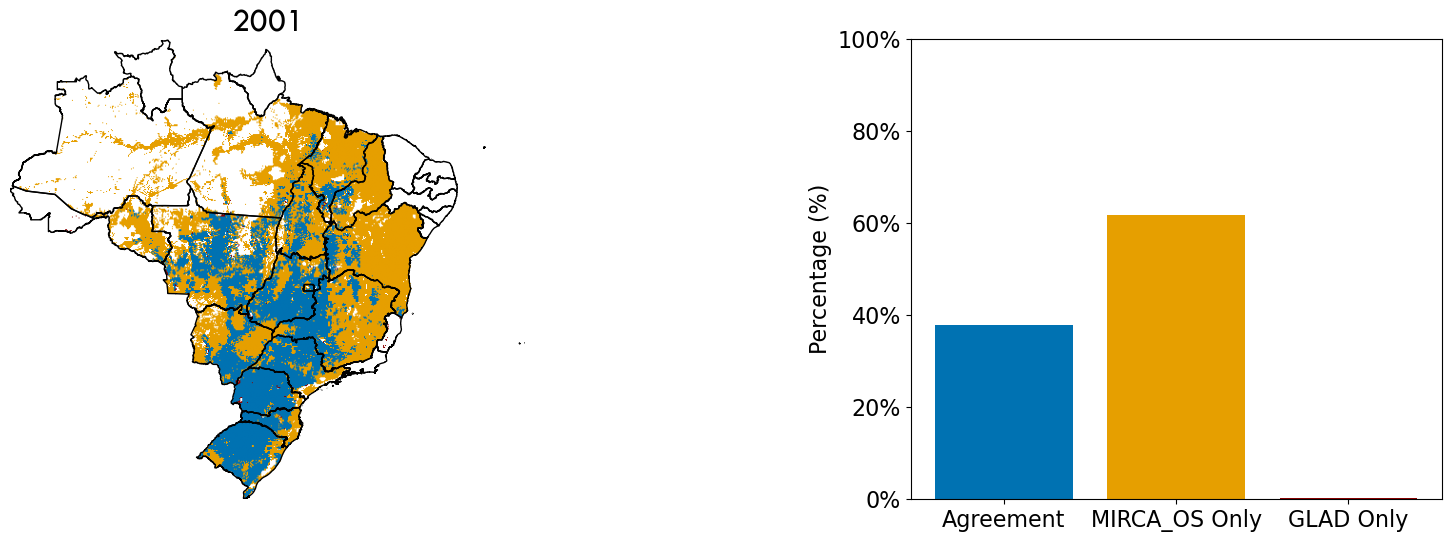

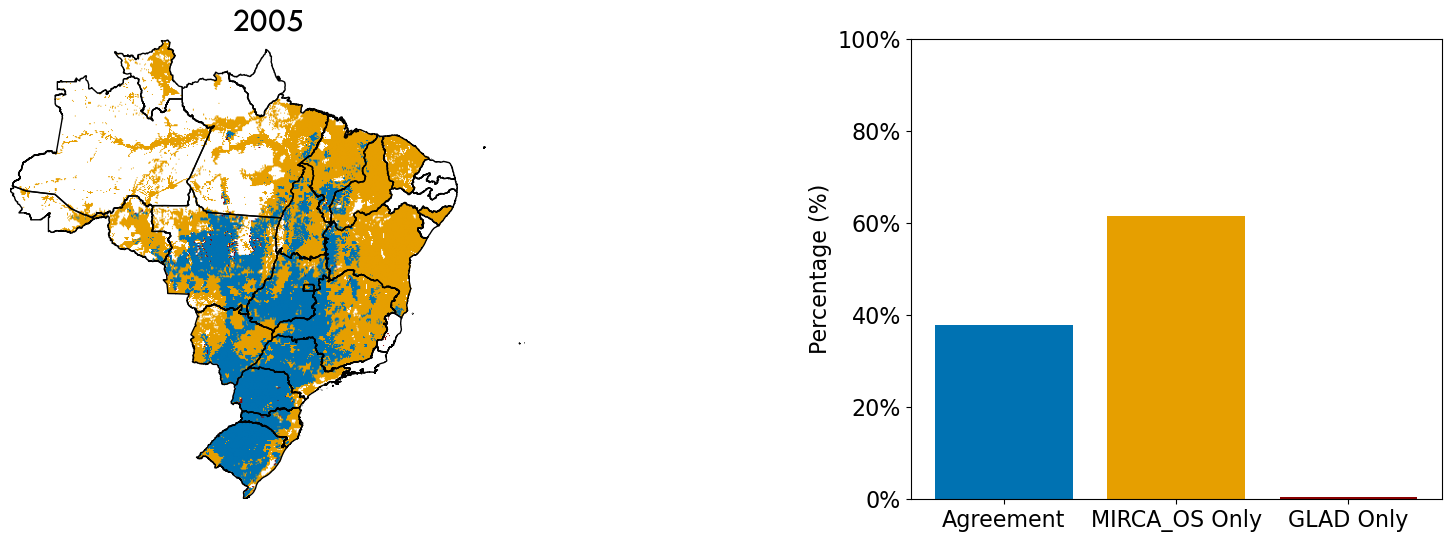

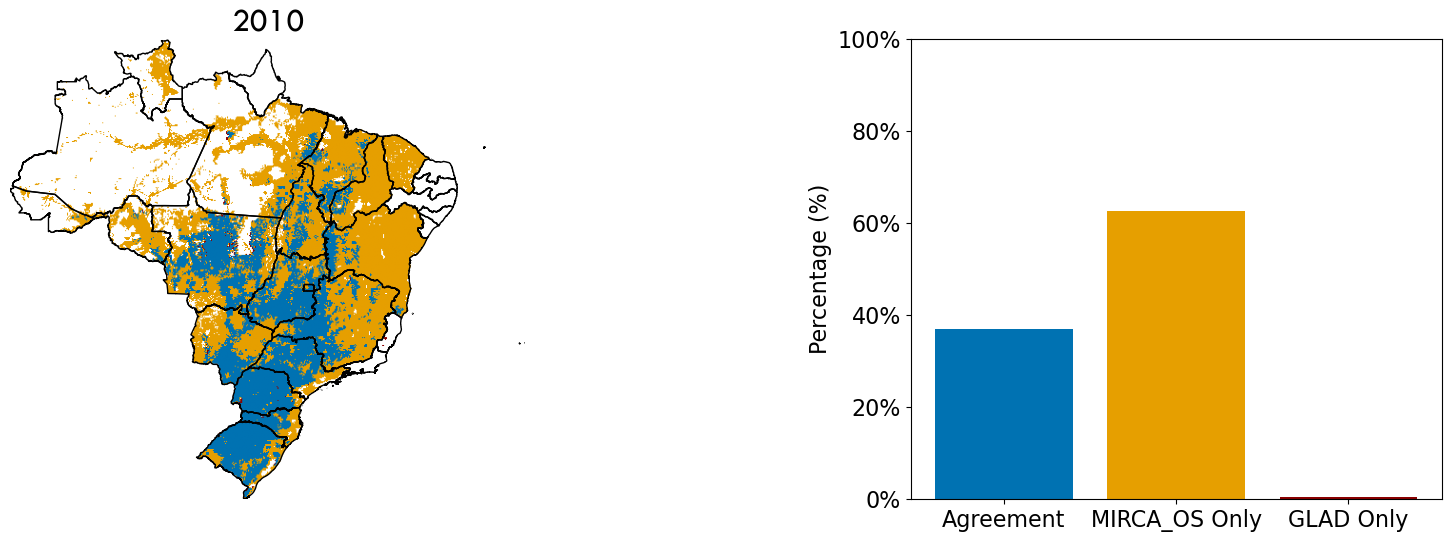

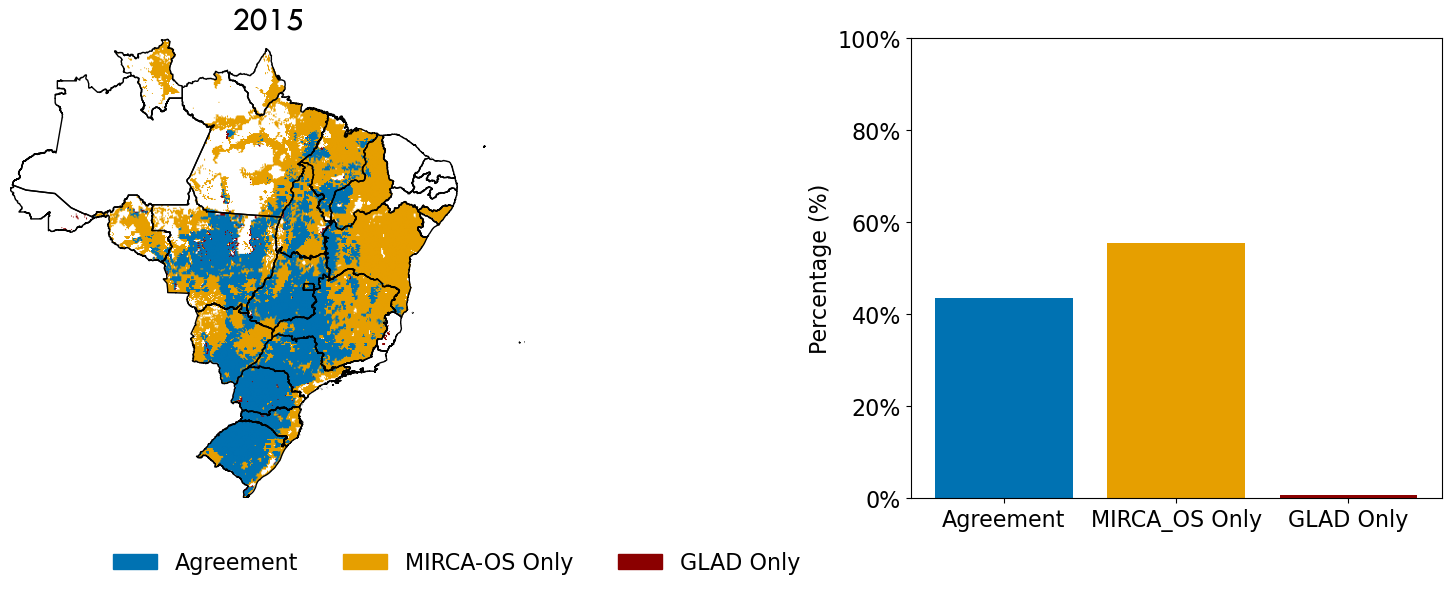

In [4]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib import font_manager
from rasterio.warp import reproject, Resampling

# Define colorblind-friendly colors for the plot
dark_blue = '#0072B2'  # Dark Blue for agreement
orange = '#E69F00'  # Orange for MIRCA-OS Only
dark_red = '#8B0000'  # Dark Red for MIRCA2000 Only

# Check if 'Tw Cen MT' font is available
if 'Tw Cen MT' not in [f.name for f in font_manager.fontManager.ttflist]:
    print('The "Tw Cen MT" font is not available on your system. Please use an available font or install "Tw Cen MT".')
    title_font = 'sans-serif'
else:
    title_font = 'Tw Cen MT'

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

# Function to reproject and resample raster data to match another raster
def reproject_and_resample(src_data, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    dst_data = np.zeros(dst_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_data, dst_transform

# Function to get the extent of a raster from its transform
def get_extent(transform, width, height):
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height
    return (left, right, bottom, top)

# Function to clean raster data
def clean_raster_data(raster_data, extreme_value_threshold=0):
    cleaned_data = np.where(raster_data < extreme_value_threshold, np.nan, raster_data)
    return cleaned_data

# Function to calculate agreement percentages for the bar chart
def calculate_percentages(agree, mirca_os_only, mirca_2000_only):
    agree_count = np.sum(agree)
    mirca_os_only_count = np.sum(mirca_os_only)
    mirca_2000_only_count = np.sum(mirca_2000_only)
    total_valid_pixels = agree_count + mirca_os_only_count + mirca_2000_only_count
    agree_pct = (agree_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_os_only_pct = (mirca_os_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_2000_only_pct = (mirca_2000_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    return agree_pct, mirca_os_only_pct, mirca_2000_only_pct

# Load the shapefile and reproject it to WGS84
shapefile_path = "D:\\PhD_Udel\\MICRA_2015\\DOwnscaling\\NASAOCE\\Shapefile\\gadm41_BRA_1.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs(epsg=4326)

# Directories for raster data
base_dir_os = "E:\\Brazil Validation\\Total Soy"
base_dir_2000 ="E:\\Brazil Validation\\Soybeans\\Resampled\\Final"
# Crop names
crops = ["2001", "2005", "2010", "2015"]

# Set up the plot dimensions and resolution
figsize = (20, 6)  # Adjusted to include space for the bar chart
dpi = 100  # Adjust the dpi to your preference for resolution

# Create a plot for each crop
for i, crop in enumerate(crops):
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=figsize, dpi=dpi, gridspec_kw={'width_ratios': [3, 1]})
    
    # Read rasters
    raster1, transform1, crs1 = read_raster(f'{base_dir_os}/{crop}.tif')
    raster2, transform2, crs2 = read_raster(f'{base_dir_2000}/{crop}.tif')

    # Reproject rasters to WGS84
    if crs1 != 'EPSG:4326':
        raster1, transform1 = reproject_and_resample(raster1, transform1, crs1, raster1.shape, transform1, 'EPSG:4326')
    if crs2 != 'EPSG:4326':
        raster2, transform2 = reproject_and_resample(raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326')

    # Ensure raster2 has the same dimensions as raster1
    raster2_resampled, _ = reproject_and_resample(
        raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326'
    )

    # Clean rasters
    raster1 = clean_raster_data(raster1)
    raster2_resampled = clean_raster_data(raster2_resampled)
    raster1 =np.maximum(raster1,0)
    raster2_resampled =np.maximum(raster2_resampled,0)
    # Compare rasters
    agree = (raster1 >=0) & (raster2_resampled >= 0)
    mirca_os_only = (raster1 > 0) & ((raster2_resampled == 0) | np.isnan(raster2_resampled))
    mirca_2000_only = (raster2_resampled > 0) & ((raster1 == 0) | np.isnan(raster1))

    # Initialize combined RGB array with white background
    combined_rgb = np.ones((raster1.shape[0], raster1.shape[1], 3))

    # Apply new colors based on the comparison
    combined_rgb[agree] = np.array([0, 114, 178]) / 255  # Dark Blue for agreement
    combined_rgb[mirca_os_only] = np.array([230, 159, 0]) / 255  # Orange for MIRCA-OS Only
    combined_rgb[mirca_2000_only] = np.array([139, 0, 0]) / 255  # Dark Red for MIRCA2000 Only

    # Plot map
    extent = get_extent(transform1, raster1.shape[1], raster1.shape[0])
    ax_map.imshow(combined_rgb, extent=extent)
    ax_map.set_title(f'{crop}', fontsize=24, fontname=title_font)
    ax_map.set_frame_on(False)
    world.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

    # Remove x and y ticks
    ax_map.set_xticks([])
    ax_map.set_yticks([])

    # Calculate percentages for the bar chart
    agree_pct, mirca_os_only_pct, mirca_2000_only_pct = calculate_percentages(agree, mirca_os_only, mirca_2000_only)

    # Plot bar chart on ax_bar
    labels = ['Agreement', 'MIRCA_OS Only', 'GLAD Only']
    percentages = [agree_pct, mirca_os_only_pct, mirca_2000_only_pct]
    ax_bar.bar(labels, percentages, color=[dark_blue, orange, dark_red])
    ax_bar.set_ylabel('Percentage (%)', fontsize=16)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_xticklabels(labels, fontsize=16)
    ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)

    # Legend
    if i == len(crops) - 1:
        legend_elements = [
            mpatches.Patch(color=dark_blue, label='Agreement'),
            mpatches.Patch(color=orange, label='MIRCA-OS Only'),
            mpatches.Patch(color=dark_red, label='GLAD Only')
        ]
        plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, fontsize=16, frameon=False, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameter to fit your plot and legend inside the figure
    plt.savefig(f'E:\\Brazil Validation\\Final Maps\\{crop}_2015.png', bbox_inches='tight')

plt.show()


Shape of 2001 before resampling: data1=(406, 482), data2=(469, 542)
Shape of 2001 after resampling: data1=(406, 482), data2_resampled=(406, 482)
Shape of 2005 before resampling: data1=(406, 483), data2=(469, 542)
Shape of 2005 after resampling: data1=(406, 483), data2_resampled=(406, 483)
Shape of 2010 before resampling: data1=(406, 483), data2=(469, 542)
Shape of 2010 after resampling: data1=(406, 483), data2_resampled=(406, 483)
Shape of 2015 before resampling: data1=(406, 483), data2=(469, 542)
Shape of 2015 after resampling: data1=(406, 483), data2_resampled=(406, 483)


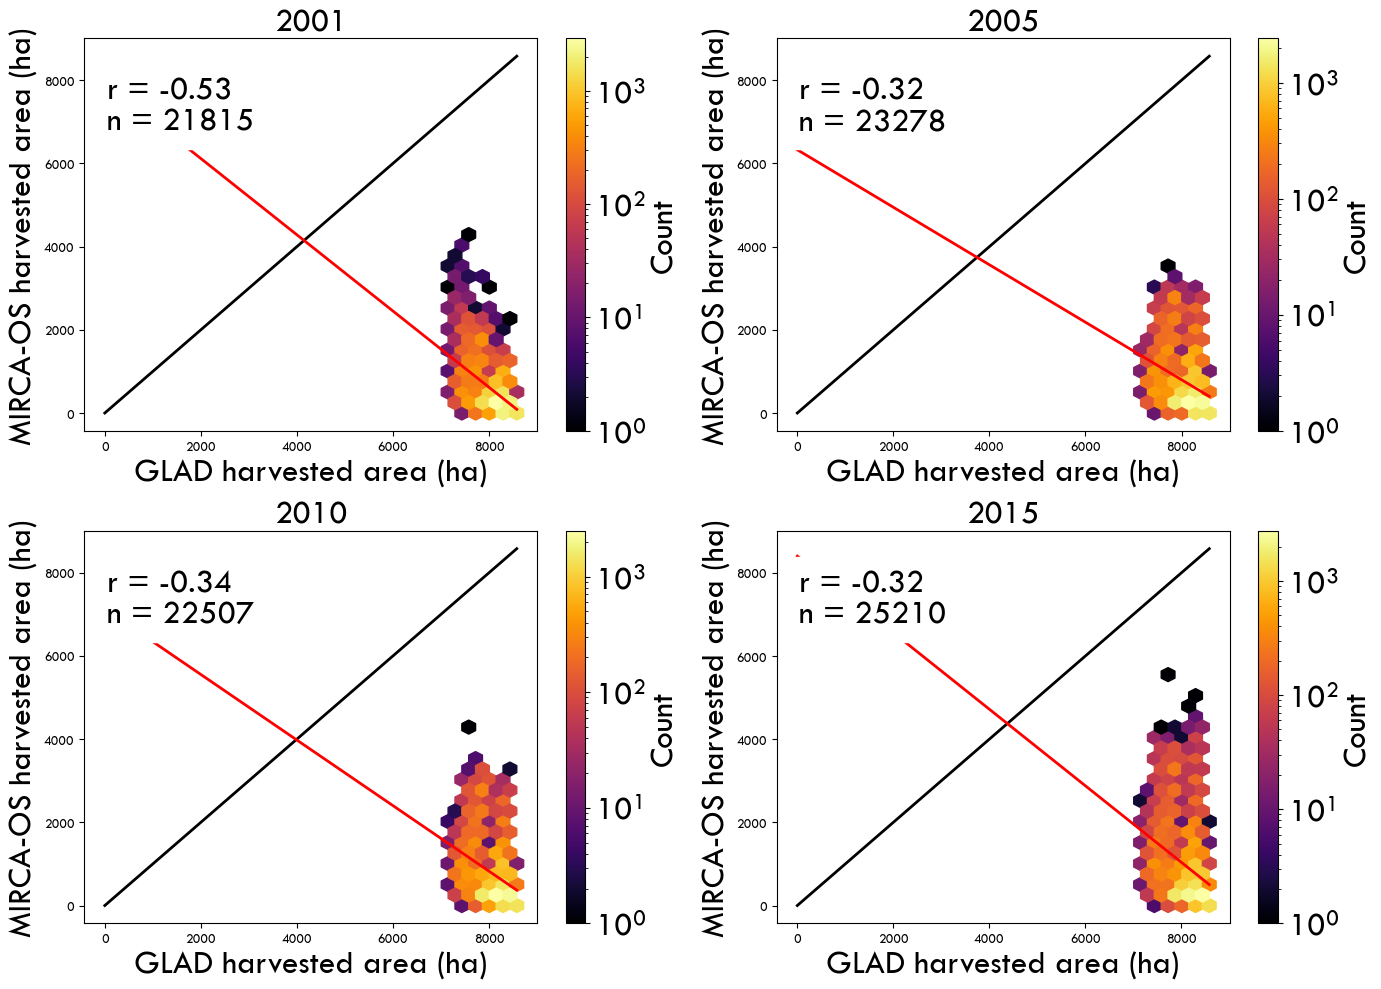

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.stats import linregress, pearsonr

# Set the font family globally for all plots
plt.rcParams['font.family'] = 'Tw Cen MT'

# Define the base font size
font_size = 24

# Define the clean_raster_data function
def clean_raster_data(raster_data, no_data_value):
    """
    Replace extreme negative and positive values in raster data with NaN while keeping valid values unchanged.
    """
    cleaned_data = np.where(raster_data <= -1e+38, np.nan, raster_data)
    cleaned_data = np.where(raster_data >= 1e+38, np.nan, cleaned_data)
    return cleaned_data

# Define the plot_scatter_and_regression function to include r_value and n_value
def plot_scatter_and_regression(ax, x, y, crop_name, r_value, n_value):
    # Ensure that we remove NaN values from the data before plotting
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    # Calculate the common range for x and y axes
    common_min = min(np.nanmin(x), np.nanmin(y))
    common_max = max(np.nanmax(x), np.nanmax(y))
    
    # Create a hexbin plot 
    hb = ax.hexbin(x, y, gridsize=30, cmap='inferno', bins='log', extent=(common_min, common_max, common_min, common_max))
    cbar = ax.figure.colorbar(hb, ax=ax, label='Count')
    cbar.ax.tick_params(labelsize=font_size)  # Set the fontsize for colorbar ticks
    cbar.set_label('Count', size=font_size)  # Set the fontsize for colorbar label

    # Add the 1:1 line
    ax.plot([common_min, common_max], [common_min, common_max], color='black', linestyle='-', linewidth=2)

    # Perform linear regression
    slope, intercept = linregress(x, y)[:2]
    ax.plot([common_min, common_max], [intercept + slope * common_min, intercept + slope * common_max], color='red', linewidth=2)

    # Add text annotation in the plot for the updated r and n values
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1
    ax.text(text_x, text_y, f'r = {r_value:.2f}\nn = {n_value}', color='black', ha='left', va='top', backgroundcolor='white', fontsize=font_size)

    # Set axis labels and title
    ax.set_xlabel(' GLAD harvested area (ha) ', fontsize=font_size)
    ax.set_ylabel('MIRCA-OS harvested area (ha)', fontsize=font_size)
    ax.set_title(f'{crop_name}', fontsize=font_size)

# Define no_data_value
no_data_value = np.nan

# Define the paths to the directories
folder1 ="E:\\Brazil Validation\\Soybeans\\Resampled\\Final"
folder2 = "E:\\Brazil Validation\\Total Soy\\MIRCA-OS"
# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

# List the raster files
rasters1 = {os.path.splitext(file)[0]: os.path.join(folder1, file) for file in os.listdir(folder1) if file.endswith('.tif')}
rasters2 = {os.path.splitext(file)[0]: os.path.join(folder2, file) for file in os.listdir(folder2) if file.endswith('.tif')}

# Function to resample raster
def resample_raster(src_data, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    dst_data = np.zeros(dst_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )
    return dst_data

# Iterate over the rasters
plot_count = 0
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Read the data and apply the cleaning function
            data1 = clean_raster_data(src1.read(1), no_data_value)
            data2 = clean_raster_data(src2.read(1), no_data_value)

            # Debugging: Print shapes of the data
            print(f"Shape of {crop_name} before resampling: data1={data1.shape}, data2={data2.shape}")

            # Resample data2 to match data1 shape and transform
            data2_resampled = resample_raster(data2, src2.transform, src2.crs, data1.shape, src1.transform, src1.crs)

            # Debugging: Print shapes after resampling
            print(f"Shape of {crop_name} after resampling: data1={data1.shape}, data2_resampled={data2_resampled.shape}")

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2_resampled = data2_resampled.flatten()

            # Ensure that we remove no_data_values from the data before analysis
            valid_mask = ~np.isnan(data1) & ~np.isnan(data2_resampled)
            data1_valid = data1[valid_mask]
            data2_valid = data2_resampled[valid_mask]

            # Calculate the Pearson correlation coefficient and count 'n' for valid data
            if len(data1_valid) > 0 and len(data2_valid) > 0:  # Proceed only if there's valid data
                r_value, _ = pearsonr(data1_valid, data2_valid)
                n_value = len(data1_valid)

                # Find the next available subplot
                ax = axs[plot_count]

                # Plot the data on the corresponding subplot axis with the correct r and n values
                plot_scatter_and_regression(ax, data1_valid, data2_valid, crop_name, r_value, n_value)

                # Increment the plot counter
                plot_count += 1
            else:
                print(f"No valid data for {crop_name} to plot.")

            # Break out of the loop if we have filled all the subplots
            if plot_count == 4:
                break

# If there are less than 4 plots, hide the last subplot
if plot_count < 4:
    for i in range(plot_count, 4):
        axs[i].set_visible(False)

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig(f'E:\\Brazil Validation\\Final Maps\\Scatter.png', bbox_inches='tight')
plt.show()


In [11]:
# import numpy as np
# import rasterio
# from rasterio.enums import Resampling
# from rasterio.warp import reproject, calculate_default_transform

# # Function to calculate the area of a pixel in hectares at a given latitude
# def pixel_area_in_hectares(lat):
#     # Constants for the calculations
#     a = 6378137  # Semi-major axis of the earth in meters
#     b = 6356752.3142  # Semi-minor axis of the earth in meters
#     e = np.sqrt(1 - (b/a)**2)  # Eccentricity

#     # Convert latitude to radians
#     lat_rad = np.radians(lat)

#     # Calculate the meridian radius of curvature
#     M = (a * (1 - e**2)) / (1 - e**2 * np.sin(lat_rad)**2)**(3/2)

#     # Calculate the prime vertical radius of curvature
#     N = a / np.sqrt(1 - e**2 * np.sin(lat_rad)**2)

#     # Length of a degree of latitude (north-south) in meters
#     lat_degree_length = np.pi / 180 * M

#     # Length of a degree of longitude (east-west) in meters
#     lon_degree_length = np.pi / 180 * np.cos(lat_rad) * N

#     # Area of one pixel in square meters
#     pixel_area_m2 = (lat_degree_length * lon_degree_length) * (0.00024999899**2)

#     # Convert to hectares (1 hectare = 10,000 square meters)
#     return pixel_area_m2 / 10000

# # Open the crop map and the 5 arc-minute area map
# with rasterio.open('E:\\Brazil Validation\\Soybeans\\Clipped\\2000.tif') as crop_src, \
#      rasterio.open('E:\\Brazil Validation\\Soybeans\\Area.tif') as area_src:

#     # Get the crop map's transform and bounds
#     crop_affine = crop_src.transform
#     crop_bounds = crop_src.bounds
    
#     # Determine the output grid shape and transform
#     dst_transform, dst_width, dst_height = calculate_default_transform(
#         crop_src.crs, area_src.crs, area_src.width, area_src.height, *area_src.bounds
#     )
    
#     # Create an empty array for the aggregated output
#     aggregate_crop = np.zeros((dst_height, dst_width), dtype=np.float32)
    
#     # Read and process the crop data in chunks
#     for ji, window in crop_src.block_windows(1):
#         # Read the crop data chunk
#         crop_chunk = crop_src.read(1, window=window)
        
#         # Get the bounds of the chunk
#         window_bounds = rasterio.windows.bounds(window, crop_affine)
        
#         # Calculate the latitudes for each row in the chunk
#         latitudes = np.linspace(window_bounds[3], window_bounds[1], crop_chunk.shape[0])
        
#         # Calculate the area of each pixel in the chunk
#         pixel_areas_ha = np.vectorize(pixel_area_in_hectares)(latitudes)
        
#         # Resample the chunk to match the 5 arc-minute grid
#         reproject(
#             source=crop_chunk,
#             destination=aggregate_crop,
#             src_transform=crop_affine,
#             src_crs=crop_src.crs,
#             dst_transform=dst_transform,
#             dst_crs=area_src.crs,
#             resampling=Resampling.sum
#         )

# # Save the aggregated crop area in hectares to a new raster
# with rasterio.open("E:\\Brazil Validation\\Soybeans\\Resampled\\2000_resampled.tif", 'w', driver='GTiff',
#                    height=dst_height, width=dst_width,
#                    count=1, dtype=np.float32,
#                    crs=area_src.crs, transform=dst_transform) as dst:
#     dst.write(aggregate_crop, 1)


C:\Users\endal\anaconda3\envs\mirca_2015\lib\site-packages\geopandas\plotting.py:482: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()
C:\Users\endal\AppData\Local\Temp\ipykernel_14488\2280157196.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_14488\2280157196.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)
C:\Users\endal\anaconda3\envs\mirca_2015\lib\site-packages\geopandas\plotting.py:482: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.draw()
C:\Users\endal\AppData\Local\Temp\ipykernel_14488\2280157196.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_14488\228

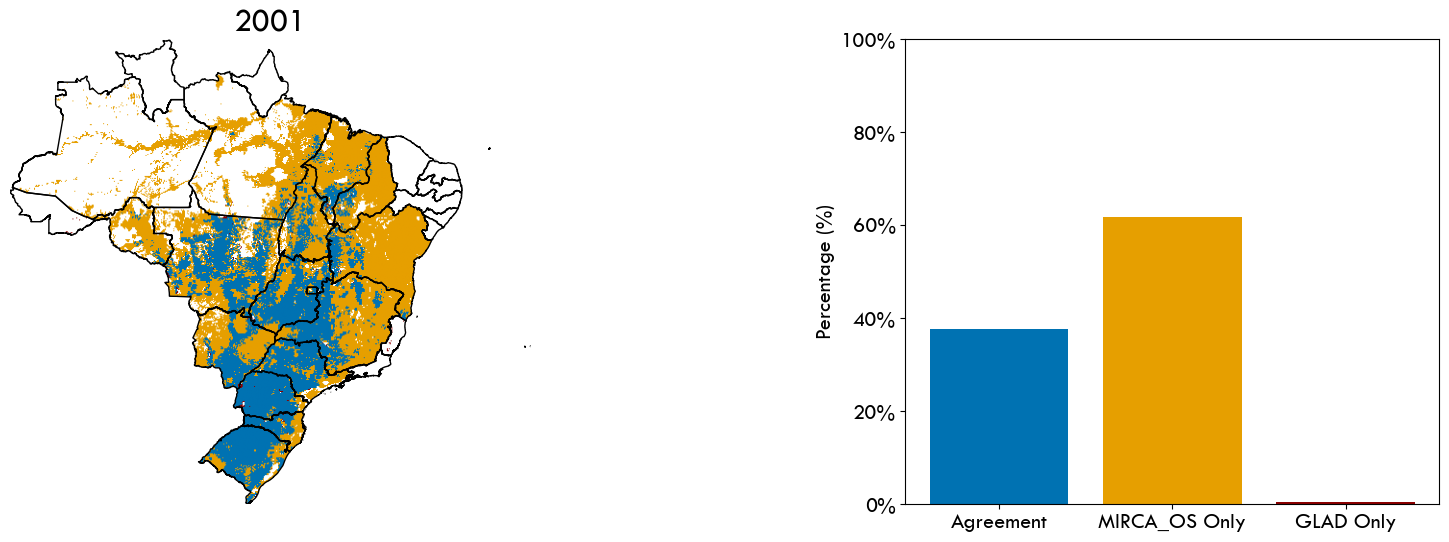

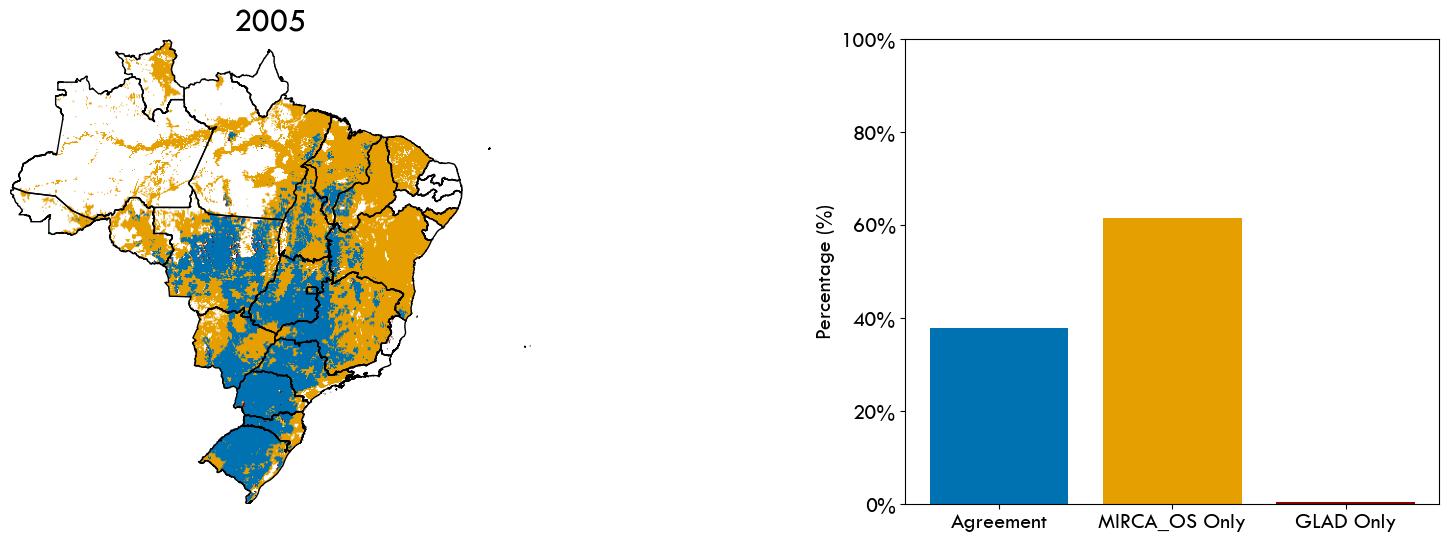

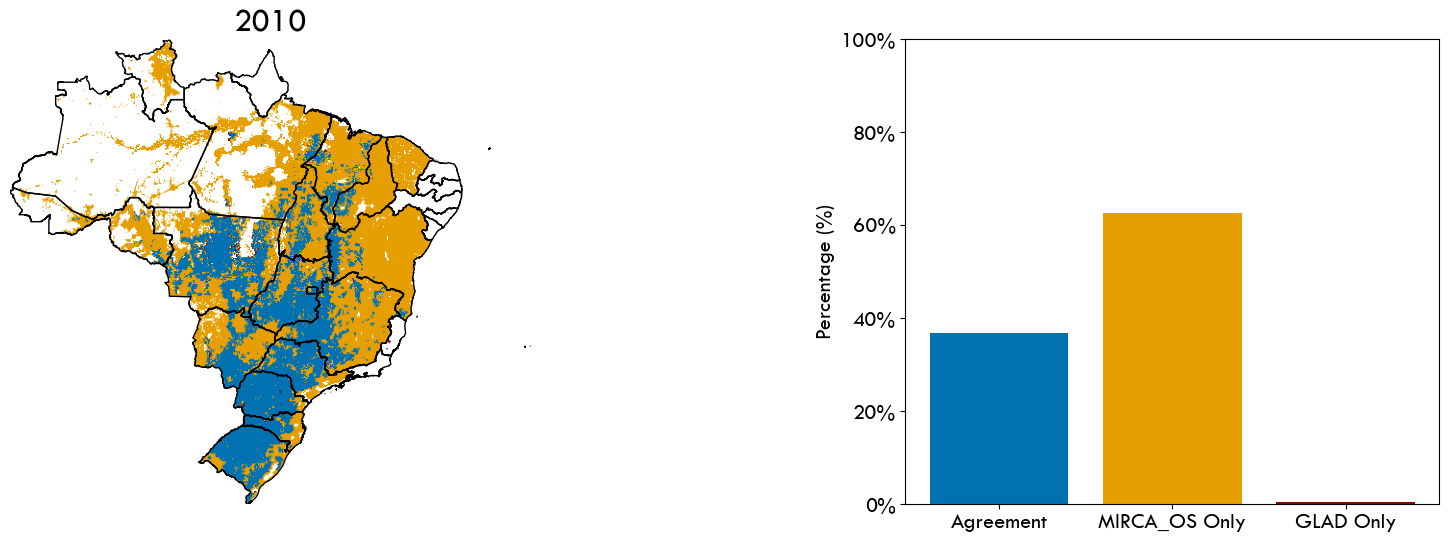

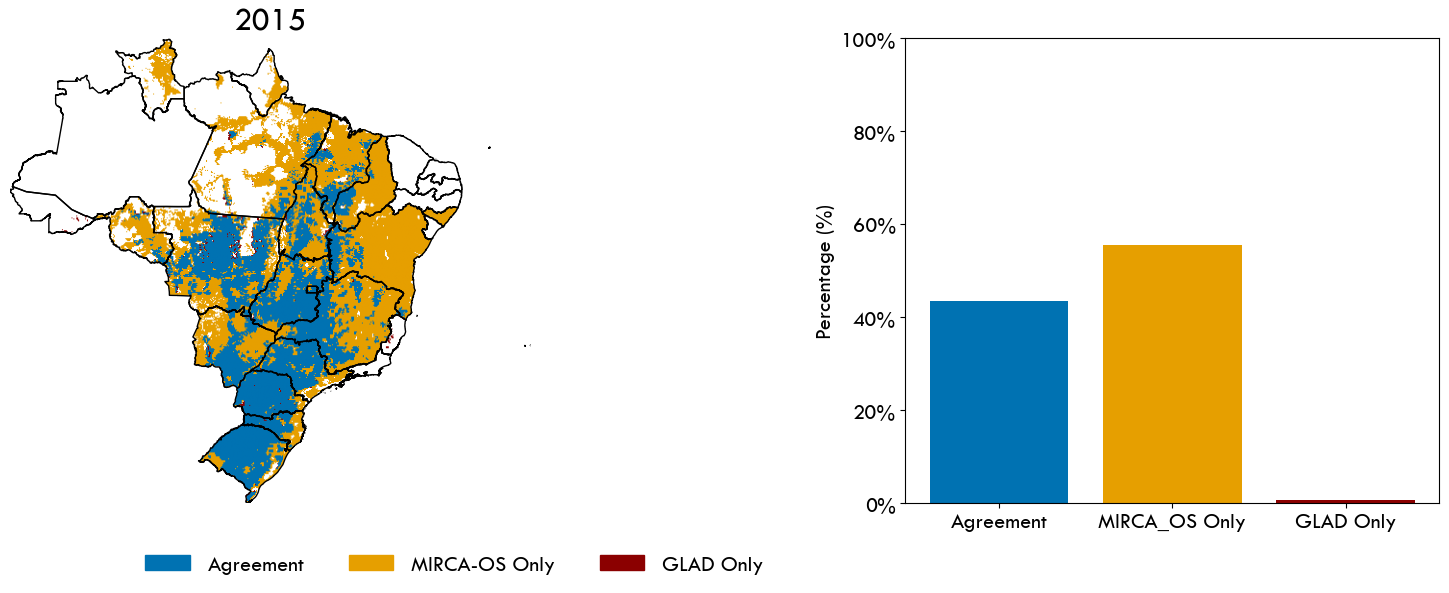

In [2]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib import font_manager
from rasterio.warp import reproject, Resampling

# Define colorblind-friendly colors for the plot
dark_blue = '#0072B2'  # Dark Blue for agreement
orange = '#E69F00'  # Orange for MIRCA-OS Only
dark_red = '#8B0000'  # Dark Red for MIRCA2000 Only

# Check if 'Tw Cen MT' font is available
if 'Tw Cen MT' not in [f.name for f in font_manager.fontManager.ttflist]:
    print('The "Tw Cen MT" font is not available on your system. Please use an available font or install "Tw Cen MT".')
    title_font = 'sans-serif'
else:
    title_font = 'Tw Cen MT'

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

# Function to reproject and resample raster data to match another raster
def reproject_and_resample(src_data, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    dst_data = np.zeros(dst_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_data, dst_transform

# Function to get the extent of a raster from its transform
def get_extent(transform, width, height):
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height
    return (left, right, bottom, top)

# Function to clean raster data
def clean_raster_data(raster_data, extreme_value_threshold=0):
    cleaned_data = np.where(raster_data < extreme_value_threshold, np.nan, raster_data)
    return cleaned_data

# Function to calculate agreement percentages for the bar chart
def calculate_percentages(agree, mirca_os_only, mirca_2000_only):
    agree_count = np.sum(agree)
    mirca_os_only_count = np.sum(mirca_os_only)
    mirca_2000_only_count = np.sum(mirca_2000_only)
    total_valid_pixels = agree_count + mirca_os_only_count + mirca_2000_only_count
    agree_pct = (agree_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_os_only_pct = (mirca_os_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_2000_only_pct = (mirca_2000_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    return agree_pct, mirca_os_only_pct, mirca_2000_only_pct

# Function to calculate IoU
def calculate_iou(agree, mirca_os_only, mirca_2000_only):
    intersection = np.sum(agree)
    union = intersection + np.sum(mirca_os_only) + np.sum(mirca_2000_only)
    iou = intersection / union if union > 0 else 0
    return iou

# Load the shapefile and reproject it to WGS84
shapefile_path = "D:\\PhD_Udel\\MICRA_2015\\DOwnscaling\\NASAOCE\\Shapefile\\gadm41_BRA_1.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs(epsg=4326)

# Directories for raster data
base_dir_os = "E:\\Brazil Validation\\Total Soy"
base_dir_2000 = "E:\\Brazil Validation\\Soybeans\\Resampled\\Final"

# Crop names
crops = ["2001", "2005", "2010", "2015"]

# Set up the plot dimensions and resolution
figsize = (20, 6)  # Adjusted to include space for the bar chart
dpi = 100  # Adjust the dpi to your preference for resolution

# Create a plot for each crop
for i, crop in enumerate(crops):
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=figsize, dpi=dpi, gridspec_kw={'width_ratios': [3, 1]})
    
    # Read rasters
    raster1, transform1, crs1 = read_raster(f'{base_dir_os}/{crop}.tif')
    raster2, transform2, crs2 = read_raster(f'{base_dir_2000}/{crop}.tif')

    # Reproject rasters to WGS84
    if crs1 != 'EPSG:4326':
        raster1, transform1 = reproject_and_resample(raster1, transform1, crs1, raster1.shape, transform1, 'EPSG:4326')
    if crs2 != 'EPSG:4326':
        raster2, transform2 = reproject_and_resample(raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326')

    # Ensure raster2 has the same dimensions as raster1
    raster2_resampled, _ = reproject_and_resample(
        raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326'
    )

    # Clean rasters
    raster1 = clean_raster_data(raster1)
    raster2_resampled = clean_raster_data(raster2_resampled)
    raster1 = np.maximum(raster1, 0)
    raster2_resampled = np.maximum(raster2_resampled, 0)
    
    # Compare rasters
    agree = (raster1 >= 0) & (raster2_resampled >= 0)
    mirca_os_only = (raster1 > 0) & ((raster2_resampled == 0) | np.isnan(raster2_resampled))
    mirca_2000_only = (raster2_resampled > 0) & ((raster1 == 0) | np.isnan(raster1))

    # Initialize combined RGB array with white background
    combined_rgb = np.ones((raster1.shape[0], raster1.shape[1], 3))

    # Apply new colors based on the comparison
    combined_rgb[agree] = np.array([0, 114, 178]) / 255  # Dark Blue for agreement
    combined_rgb[mirca_os_only] = np.array([230, 159, 0]) / 255  # Orange for MIRCA-OS Only
    combined_rgb[mirca_2000_only] = np.array([139, 0, 0]) / 255  # Dark Red for MIRCA2000 Only

    # Plot map
    extent = get_extent(transform1, raster1.shape[1], raster1.shape[0])
    ax_map.imshow(combined_rgb, extent=extent)
    ax_map.set_title(f'{crop}', fontsize=24, fontname=title_font)
    ax_map.set_frame_on(False)
    world.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

    # Remove x and y ticks
    ax_map.set_xticks([])
    ax_map.set_yticks([])

    # Calculate percentages for the bar chart
    agree_pct, mirca_os_only_pct, mirca_2000_only_pct = calculate_percentages(agree, mirca_os_only, mirca_2000_only)

    # Calculate IoU score
    iou = calculate_iou(agree, mirca_os_only, mirca_2000_only)

    # Plot bar chart on ax_bar
    labels = ['Agreement', 'MIRCA_OS Only', 'GLAD Only']
    percentages = [agree_pct, mirca_os_only_pct, mirca_2000_only_pct]
    ax_bar.bar(labels, percentages, color=[dark_blue, orange, dark_red])
    ax_bar.set_ylabel('Percentage (%)', fontsize=16)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_xticklabels(labels, fontsize=16)
    ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)

    # Display IoU score on the bar chart
#     ax_bar.text(1.5, 105, f'IoU: {iou:.2f}', ha='center', va='center', fontsize=20, fontname=title_font, bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

    # Legend
    if i == len(crops) - 1:
        legend_elements = [
            mpatches.Patch(color=dark_blue, label='Agreement'),
            mpatches.Patch(color=orange, label='MIRCA-OS Only'),
            mpatches.Patch(color=dark_red, label='GLAD Only')
        ]
        plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, fontsize=16, frameon=False, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameter to fit your plot and legend inside the figure
    plt.savefig(f'E:\\Brazil Validation\\Final Maps\\{crop}_2015.png', bbox_inches='tight')

plt.show()


Crop: 2001, Number of valid data points: 29796
Crop: 2005, Number of valid data points: 31005
Crop: 2010, Number of valid data points: 30211
Crop: 2015, Number of valid data points: 31536


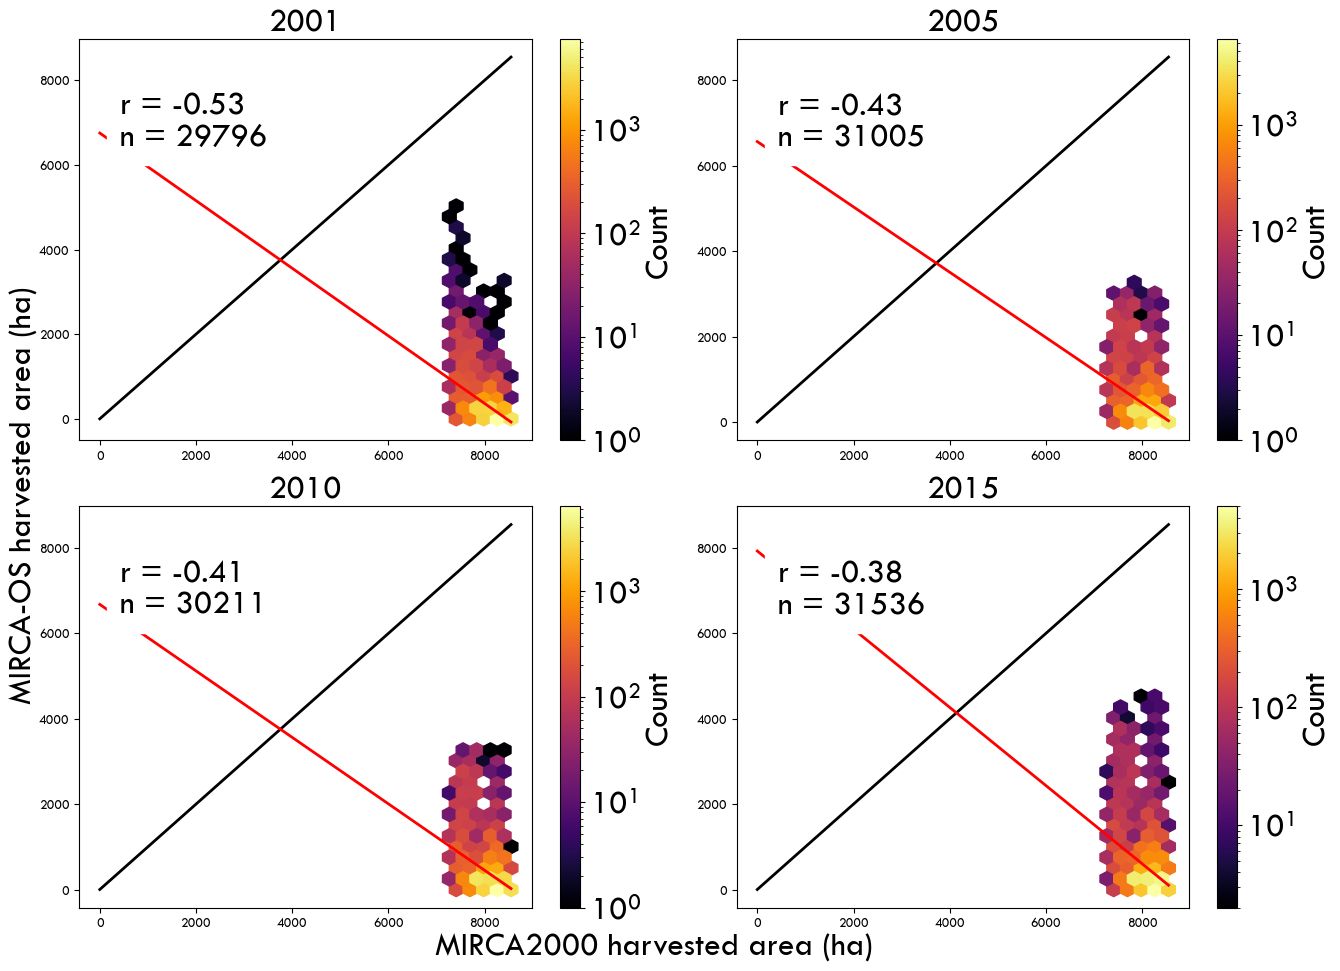

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from scipy.stats import linregress, pearsonr

# Set the font family globally for all plots
plt.rcParams['font.family'] = 'Tw Cen MT'

# Define the base font size
font_size = 24

# Define the clean_raster_data function
def clean_raster_data(raster_data, nan_value):
    """
    Replace the given NaN value in raster data with actual NaNs and zero for negative values.
    """
    raster_data = np.where(raster_data == nan_value, np.nan, raster_data)
    return np.where((raster_data < 0), np.nan, raster_data)

# Define the plot_scatter_and_regression function
def plot_scatter_and_regression(ax, x, y, crop_name, n_valid, common_min, common_max):
    x = x
    y = y
    
    # Calculate the Pearson correlation coefficient
    r, _ = pearsonr(x, y)

    # Create a hexbin plot 
    hb = ax.hexbin(x, y, gridsize=30, cmap='inferno', bins='log', extent=(common_min, common_max, common_min, common_max))
    cbar = ax.figure.colorbar(hb, ax=ax, label='Count')
    cbar.ax.tick_params(labelsize=font_size)  # Set the fontsize for colorbar ticks
    cbar.set_label('Count', size=font_size)  # Set the fontsize for colorbar label

    # Add the 1:1 line
    ax.plot([common_min, common_max], [common_min, common_max], color='black', linestyle='-', linewidth=2)

    # Perform linear regression
    slope, intercept = linregress(x, y)[:2]
    ax.plot([common_min, common_max], [intercept + slope * common_min, intercept + slope * common_max], color='red', linewidth=2)

    # Add text annotation in the plot
    text_x = common_min + (common_max - common_min) * 0.05
    text_y = common_max - (common_max - common_min) * 0.1
    ax.text(text_x, text_y, f'r = {r:.2f}\nn = {n_valid}', color='black', ha='left', va='top', backgroundcolor='white', fontsize=font_size)

    # Set title
    ax.set_title(f'{crop_name}', fontsize=font_size)

# Define the paths to the directories
folder1 = "E:\\Brazil Validation\\Soybeans\\Resampled\\Final"
folder2 =  "E:\\Brazil Validation\\Total Soy"
# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

# List the raster files
rasters1 = {os.path.splitext(file)[0]: os.path.join(folder1, file) for file in os.listdir(folder1) if file.endswith('.tif')}
rasters2 = {os.path.splitext(file)[0]: os.path.join(folder2, file) for file in os.listdir(folder2) if file.endswith('.tif')}

# Define the NaN value
nan_value = -3.40282306074e+38

# Determine the maximum dimensions for resampling
max_height = 0
max_width = 0
for raster_path in list(rasters1.values()) + list(rasters2.values()):
    with rasterio.open(raster_path) as src:
        max_height = max(max_height, src.height)
        max_width = max(max_width, src.width)

# Initialize variables to find the common min and max values
common_min_x = float('inf')
common_max_x = float('-inf')
common_min_y = float('inf')
common_max_y = float('-inf')

# Function to resample raster to match the maximum dimensions
def resample_raster(src, max_height, max_width):
    data = src.read(
        out_shape=(
            src.count,
            max_height,
            max_width
        ),
        resampling=Resampling.bilinear
    )
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    return data[0], transform

# Iterate over the rasters to determine the common axis limits
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Resample the rasters to the maximum dimensions
            data1, _ = resample_raster(src1, max_height, max_width)
            data2, _ = resample_raster(src2, max_height, max_width)
            
            # Clean the data
            data1 = clean_raster_data(data1, nan_value)
            data2 = clean_raster_data(data2, nan_value)

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Filter out invalid data points
            valid_mask = (data1 >= 0) & (data2 >= 0)
            data1 = data1[valid_mask]
            data2 = data2[valid_mask]

            # Remove NaN values from both datasets
            mask = ~np.isnan(data1) & ~np.isnan(data2)
            data1 = data1[mask]
            data2 = data2[mask]

            # Update common min and max values
            common_min_x = min(common_min_x, np.nanmin(data1))
            common_max_x = max(common_max_x, np.nanmax(data1))
            common_min_y = min(common_min_y, np.nanmin(data2))
            common_max_y = max(common_max_y, np.nanmax(data2))

common_min = min(common_min_x, common_min_y)
common_max = max(common_max_x, common_max_y)

# Iterate over the rasters again to plot the data
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Resample the rasters to the maximum dimensions
            data1, _ = resample_raster(src1, max_height, max_width)
            data2, _ = resample_raster(src2, max_height, max_width)

            # Clean the data
            data1 = clean_raster_data(data1, nan_value)
            data2 = clean_raster_data(data2, nan_value)

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Filter out invalid data points
            valid_mask = (data1 >= 0) & (data2 >= 0)
            data1 = data1[valid_mask]
            data2 = data2[valid_mask]

            # Remove NaN values from both datasets
            mask = ~np.isnan(data1) & ~np.isnan(data2)
            data1 = data1[mask]
            data2 = data2[mask]

            # Calculate the number of valid data points for this crop
            n_valid = len(data1)
            print(f'Crop: {crop_name}, Number of valid data points: {n_valid}')  # Debugging statement

            # Find the next available subplot
            ax = next((ax for ax in axs if not hasattr(ax, 'data_plotted')), None)
            if ax is None:
                print("No more empty subplots available.")
                break

            # Plot the data on the corresponding subplot axis
            plot_scatter_and_regression(ax, data1, data2, crop_name, n_valid, common_min, common_max)
            
            # Mark this axis as having data plotted on it
            ax.data_plotted = True

# Set common x and y labels
fig.text(0.5, 0.04, 'MIRCA2000 harvested area (ha)', ha='center', fontsize=font_size)
fig.text(0.04, 0.5, 'MIRCA-OS harvested area (ha)', va='center', rotation='vertical', fontsize=font_size)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust rect to fit common labels
# plt.savefig('E:\\US Validation\\Maps\\Scatter\\2015.png', bbox_inches='tight')
plt.show()
